# **Capstone 2 - West Nile Virus Prediction**<br>

West Nile virus (WNV), according to [Centers for Disease Control & Prevention (CDC)](https://www.cdc.gov/westnile/index.html#:~:text=West%20Nile%20virus%20(WNV)%20is,summer%20and%20continues%20through%20fall.), is the leading cause of mosquito-borne disease in the continental United States.  It is most commonly spread to people by the bite of an infected mosquito. WNV usually occurs during mosquito seasons in summer and fall. There are no vaccines to prevent or medications to treat WNV in people.<br>



**The Problem Statement:**

The objective of this project is to analyze the data provided, build a model and predict if WNV is present at a location in Chicago. 

In [527]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

## **0) Loading the Data**

Downloading Data from Kaggle into Colab

In [429]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [430]:
#! pip install -q kaggle

In [431]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data'
#changing the working directory 
#%cd /content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data

# Kaggle API command for the dataset
#! kaggle competitions download -c 'predict-west-nile-virus'

In [432]:
#check content in the directory
#!ls

In [433]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

Checking the initial content of the data

In [434]:
#Establish the data directory
mapdata_txt = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/mapdata_copyright_openstreetmap_contributors.txt'
spray_org = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/spray.csv'
test_org = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/test.csv'
train_org = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/train.csv'
weather_org = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/weather.csv'

In [435]:
#train data
train_raw = pd.read_csv(train_org, parse_dates=['Date'])
train_raw.head(2).T

,0,1
Date,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,..."
Species,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Block,41,41
Street,N OAK PARK AVE,N OAK PARK AVE
Trap,T002,T002
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL"
Latitude,41.9547,41.9547
Longitude,-87.801,-87.801
AddressAccuracy,9,9


In [436]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

In [437]:
#weather data
weather_raw = pd.read_csv(weather_org, parse_dates=['Date'])
weather_raw.head(2).T

,0,1
Station,1,2
Date,2007-05-01 00:00:00,2007-05-01 00:00:00
Tmax,83,84
Tmin,50,52
Tavg,67,68
Depart,14,M
DewPoint,51,51
WetBulb,56,57
Heat,0,0
Cool,2,3


In [438]:
weather_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [439]:
train_raw.shape, weather_raw.shape

((10506, 12), (2944, 22))

## **1) Understanding the Data & Data Cleaning**




According to National Center for Biotechnology Information, [Culex mosquitoes](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3485754/) are accepted as the primary global transmission vector. <br>

Comprhensively, these are the mosquito breeds identified by CDC which could cause WNV - 
https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf

A few other facts in relation to Culex mosquitoes according to [CDC](https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html):


*   It takes 7-10 days for a Culex mosquito egg to develop into an adult Culex mosquito
*   Adult female mosquitos usually lay eggs in fresh or stagnant water, including barrels, unmaintained swimming pools, puddles, creaks, marsh areas
*   Once an adult turned from pupa, it flies away. Their flying distance is up to 2 miles (or 3.2 km)
*   According to [Pestworld](https://www.pestworld.org/pest-guide/mosquitoes/culex-mosquitoes/#:~:text=Culex%20mosquitoes%20are%20usually%20about,active%20at%20dawn%20and%20dusk.), they are most active at dawn or dusk







From the types of mosquitos identified in the dataset, basically all could contributed to WNV. Culex Pipens or Restuans were the most prevailing types of moquitos trapped.



## **1.1) The Training Data**




In [440]:
#understanding the date range of the training data
train_raw['Date'].min(), train_raw['Date'].max()

(Timestamp('2007-05-29 00:00:00'), Timestamp('2013-09-26 00:00:00'))

In [441]:
#if there are null values in the training data
train_raw.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [442]:
#check for duplicated columns - defined as all records in the row is identical
train_raw_duplicated = train_raw[train_raw.duplicated()].value_counts().sum()
total_records = train_raw.index.value_counts().sum()
print(f'Total number of records: {total_records}')
print(f'Number of duplicated rows: {train_raw_duplicated}')
print(f'Percentage of duplicated records: {train_raw_duplicated/ total_records*100:.2f}%')

Total number of records: 10506
Number of duplicated rows: 813
Percentage of duplicated records: 7.74%


In [443]:
#dropping duplicated columns - keeping last records
train_raw = train_raw.drop_duplicates(subset=None, keep='first', inplace=False)

In [444]:
print(f'Total number of records after dropping duplicates: {train_raw.shape[0]}')

Total number of records after dropping duplicates: 9693


In [445]:
# adding year and month column for future EDA
train_raw['Year'] = train_raw['Date'].dt.year
train_raw['Year-Month'] = train_raw['Date'].dt.to_period('M')
train_raw['Year-Week'] = train_raw['Date'].dt.strftime('%Y-%W')
train_raw.head(2).T

,0,1
Date,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,..."
Species,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Block,41,41
Street,N OAK PARK AVE,N OAK PARK AVE
Trap,T002,T002
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL"
Latitude,41.9547,41.9547
Longitude,-87.801,-87.801
AddressAccuracy,9,9


In [446]:
#merging rows with mosquitos in the trap > 50
train_grouped = train_raw.groupby(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'WnvPresent',
       'Year', 'Year-Month', 'Year-Week'])['NumMosquitos'].sum().reset_index()
train_grouped.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,WnvPresent,Year,Year-Month,Year-Week,NumMosquitos
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,2007,2007-05,2007-22,1
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,2007,2007-05,2007-22,2


In [447]:
train_grouped.shape

(8610, 15)

## **1.2) The Weather Data**




In [448]:
#understanding the date range of the weather data
weather_raw['Date'].min(), weather_raw['Date'].max()

(Timestamp('2007-05-01 00:00:00'), Timestamp('2014-10-31 00:00:00'))

In [449]:
#if there are null values in the weather data
weather_raw.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [450]:
#check for duplicated columns - defined as all records in the row is identical
weather_raw_duplicated = weather_raw[weather_raw.duplicated()].value_counts().sum()
print(f'Number of duplicated rows: {weather_raw_duplicated}')

Number of duplicated rows: 0


In [451]:
weather_raw.shape

(2944, 22)

In [452]:
#check for missing data where value 'M' identified in a column
weather_raw.isin(['M']).sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

As there are two different weather stations, checking to see if the dataset differs if being split by stations.

In [453]:
station_1 = weather_raw[weather_raw['Station']==1]
station_2 = weather_raw[weather_raw['Station']==2]

In [454]:
station_1.isin(['M']).sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
Depart            0
DewPoint          0
WetBulb           3
Heat              0
Cool              0
Sunrise           0
Sunset            0
CodeSum           0
Depth             0
Water1         1472
SnowFall          0
PrecipTotal       0
StnPressure       2
SeaLevel          5
ResultSpeed       0
ResultDir         0
AvgSpeed          0
dtype: int64

In [455]:
station_2.isin(['M']).sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           1
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         1472
SnowFall       1472
PrecipTotal       2
StnPressure       2
SeaLevel          4
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

Most items missing in station 2 exists in station one, for filling in missing data, suggesting to bring forward info already existed in station 1 by forward fill. First step will require cleaning missing data under station 1.

In [456]:
station_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 2942
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      1472 non-null   int64         
 1   Date         1472 non-null   datetime64[ns]
 2   Tmax         1472 non-null   int64         
 3   Tmin         1472 non-null   int64         
 4   Tavg         1472 non-null   object        
 5   Depart       1472 non-null   object        
 6   DewPoint     1472 non-null   int64         
 7   WetBulb      1472 non-null   object        
 8   Heat         1472 non-null   object        
 9   Cool         1472 non-null   object        
 10  Sunrise      1472 non-null   object        
 11  Sunset       1472 non-null   object        
 12  CodeSum      1472 non-null   object        
 13  Depth        1472 non-null   object        
 14  Water1       1472 non-null   object        
 15  SnowFall     1472 non-null   object        
 16  Precip

In [457]:
# filling in missing value from station 1
station_1['WetBulb'] = station_1['WetBulb'].replace('M',0).astype(float)
station_1['StnPressure'] = station_1['StnPressure'].replace('M',0).astype(float)
station_1['SeaLevel'] = station_1['SeaLevel'].replace('M',0).astype(float)

#clean up - in sunrise/ sunset column
weather_raw['Sunrise'] = weather_raw['Sunrise'].replace('-', np.nan)
weather_raw['Sunset'] = weather_raw['Sunset'].replace('-', np.nan)

#clean up "Trace" amount in the data for PrecipTotal
weather_raw['PrecipTotal'] = weather_raw['PrecipTotal'].replace(['M','  T'], 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [458]:
# replace M for missing values to NaN
weather_raw = weather_raw.replace('M', np.nan)

In [459]:
# forward fill missing values from station 1
weather_raw = weather_raw.ffill(axis=1)

In [460]:
#dropping columns Depth, Snowfall related data and CodeSum for now
weather = weather_raw.drop(['Depth', 'Water1', 'SnowFall', 'CodeSum'], axis=1)

In [461]:
# changing dtype from object to float
column_headers = weather.select_dtypes(include='object').columns.tolist()

for header in column_headers:
  weather[header] = weather[header].astype(float)

In [462]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   float64       
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   float64       
 3   Tmin         2944 non-null   float64       
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   float64       
 6   DewPoint     2944 non-null   float64       
 7   WetBulb      2944 non-null   float64       
 8   Heat         2944 non-null   float64       
 9   Cool         2944 non-null   float64       
 10  Sunrise      2944 non-null   float64       
 11  Sunset       2944 non-null   float64       
 12  PrecipTotal  2944 non-null   float64       
 13  StnPressure  2944 non-null   float64       
 14  SeaLevel     2944 non-null   float64       
 15  ResultSpeed  2944 non-null   float64       
 16  Result

In [463]:
#averaging the weather data across the 2 stations, as such, it can be merged with the training data
weather_agg = pd.pivot_table(weather,index=['Date'],aggfunc=np.mean)
weather_agg.shape

(1472, 17)

## **1.3) Merging Training & Weather Data Together**




In [464]:
#merging train_raw & weather_agg together
df_raw = train_raw.merge(weather_agg, on='Date')

In [465]:
df_raw.head(2).T

,0,1
Date,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,..."
Species,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Block,41,41
Street,N OAK PARK AVE,N OAK PARK AVE
Trap,T002,T002
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL"
Latitude,41.9547,41.9547
Longitude,-87.801,-87.801
AddressAccuracy,9,9


In [466]:
df_raw.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Year-Month', 'Year-Week',
       'AvgSpeed', 'Cool', 'Depart', 'DewPoint', 'Heat', 'PrecipTotal',
       'ResultDir', 'ResultSpeed', 'SeaLevel', 'Station', 'StnPressure',
       'Sunrise', 'Sunset', 'Tavg', 'Tmax', 'Tmin', 'WetBulb'],
      dtype='object')

In [467]:
#dropping columns which may not facilitate further analysis
df = df_raw.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'Station'], axis=1)

In [468]:
df.shape

(9693, 27)

## **2) EDA & Visualization**




Text(0.5, 1.0, 'Types of Mosquitos recorded in the Traps')

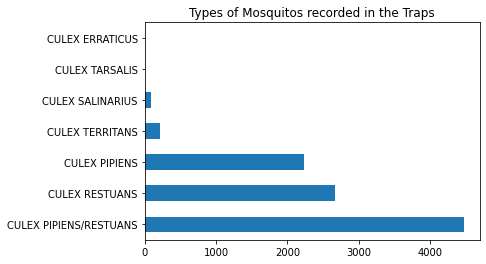

In [469]:
#Types of mosquitos discovered in the traps
df['Species'].value_counts().plot(kind='barh')
plt.title('Types of Mosquitos recorded in the Traps')

Text(0.5, 1.0, '% Traps with West Nile Virus Present')

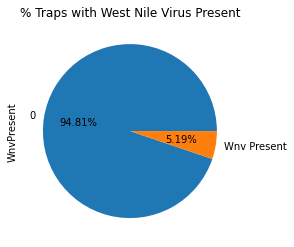

In [470]:
labels = ['0', 'Wnv Present'] 
df['WnvPresent'].value_counts().plot(kind='pie', labels=labels, autopct='%.2f%%')
plt.title('% Traps with West Nile Virus Present')

In [471]:
# Types of mosquitos identified where Wnv is positive
Wnv_present = df['Species'].where(df['WnvPresent']==1)
Wnv_present.value_counts()

CULEX PIPIENS/RESTUANS    246
CULEX PIPIENS             208
CULEX RESTUANS             49
Name: Species, dtype: int64

The data suggests that Culex Pipens or Restuans were the mosquito breeds which causes Wnv in Chicago area.

## **3) Pre-Processing & Modelling**




## **3.1) Building the features for modelling**




As some of the data which could be an important feature is not built in a way to facilitate model building, following clean-ups will be done: <br>


*   *Mosquito types* - one hot coding required, breeds which contributes to Wnv will be retained while other breeds will be classified into "others".
*   *Latitude and Longitude* - grouping into clusters instead of treating them into 2 numeric features


3.1.1) Hot coding Mosquito Types

In [472]:
df['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [473]:
df['Species'] = df['Species'].replace(['CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS', 'CULEX ERRATICUS'], 'OTHERS')

In [474]:
#one hot coding mosquito types
mos_code = pd.get_dummies(df['Species'], prefix= 'Species')
mos_code

,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_OTHERS
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,0,1,0
...,...,...,...,...
9688,0,1,0,0
9689,0,1,0,0
9690,0,1,0,0
9691,0,1,0,0


In [475]:
#merge dataframes together
df = df.join(mos_code, how='outer')

3.1.2) Transforming Latitude and Longitude data into Clusters

DBscan has been chosen as the method to perform clustering on the lon/ lat data, as it helps to differentiate high-density vs low-desnity points. 

In [476]:
#clustering the lon/lat data 
coords = df[['Longitude', 'Latitude']].to_numpy()
dbscan = DBSCAN(eps=2/6371., min_samples=50, algorithm='ball_tree', metric='haversine')
clusters = pd.DataFrame(dbscan.fit_predict(coords))
df['Cluster'] = clusters

In [477]:
#building the initial set of features, dropping columns clustered/ encoded/ in object or datetime format
features_raw = df[['AddressAccuracy', 'NumMosquitos', 'AvgSpeed', 'Cool', 'Depart', 'DewPoint', 'Heat', 'PrecipTotal',
               'ResultDir', 'ResultSpeed', 'SeaLevel', 'StnPressure', 'Sunrise', 'Sunset', 'Tavg', 'Tmax', 'Tmin', 'WetBulb', 'Species_CULEX PIPIENS',
               'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS', 'Species_OTHERS', 'Cluster']]

In [478]:
features_raw.shape

(9693, 23)

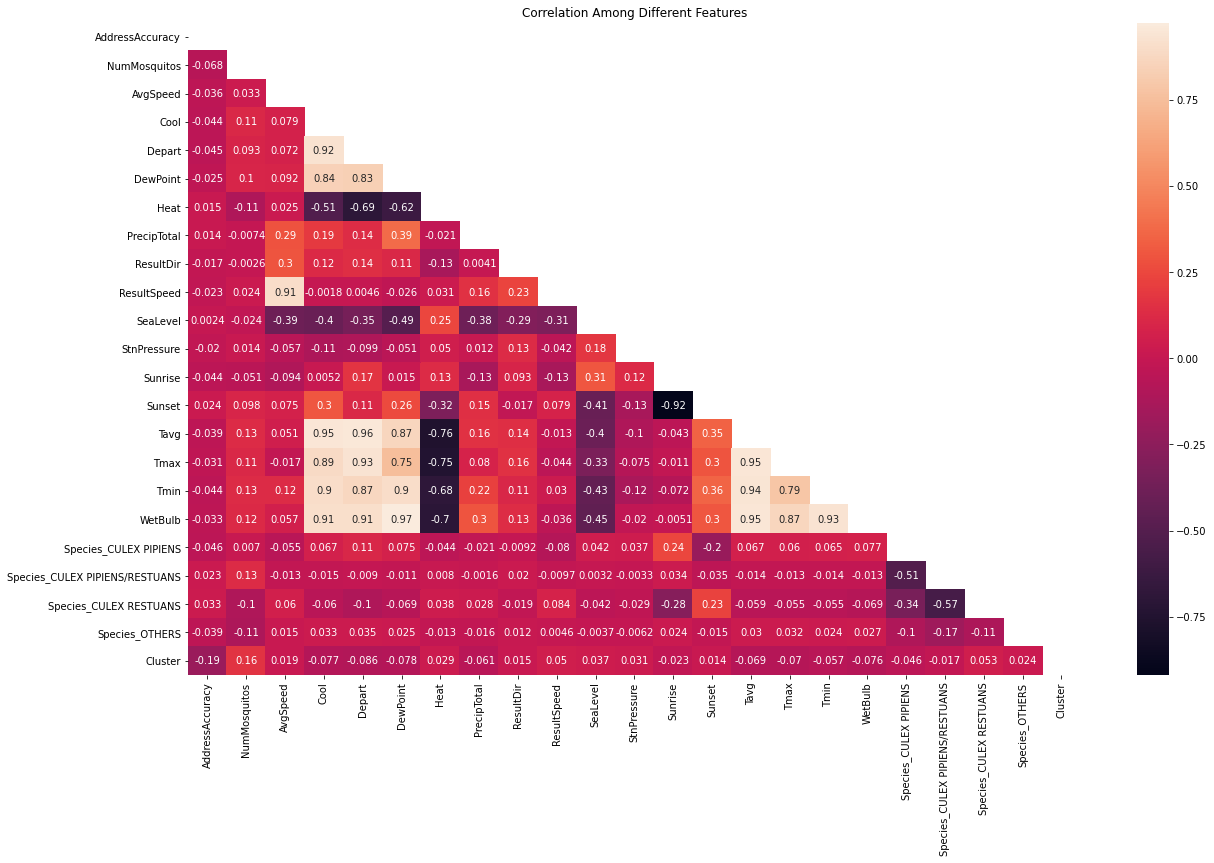

In [479]:
#understanding the correlation between the features
matrix = np.triu(features_raw.corr())
plt.figure(figsize=(20,12))
plt.title('Correlation Among Different Features')
sns.heatmap(features_raw.corr(), annot=True, mask=matrix)

There are a few features almost perfectly correlated with each other. <br>
- AvgSpeed, Tavg, Wetbulb, Cool, Depart <br>

As the features are supposed to be independent variable. These features should be removed to avoid collinearity.

## **3.2) Pre-Processing**




3.2.1) Train/ Test Split & Scaling the Data

In [480]:
features = df[['AddressAccuracy', 'NumMosquitos', 'DewPoint', 'Heat', 'PrecipTotal',
               'ResultDir', 'ResultSpeed', 'SeaLevel', 'StnPressure', 'Sunrise', 'Sunset', 'Tmax', 'Tmin', 'Species_CULEX PIPIENS',
               'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS', 'Species_OTHERS', 'Cluster']]

In [481]:
features.shape

(9693, 18)

In [482]:
X = features
Y = df['WnvPresent']

In [483]:
#scaling the data - not normally distributed therefore using MinMax Scaler
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

In [484]:
# Train Test split
X_train, x_test, Y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.25, random_state=1)

3.2.2) Oversampling

Oversampling is required because we're dealing with very imbalanced data for Wnv present. 

In [485]:
smote = SMOTE(random_state=1, ratio='minority')
X_train, Y_train = smote.fit_resample(X_train, Y_train)
x_test, y_test = smote.fit_resample(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **3.3) Building the Model**




3.3.1) Logistic Regression Model

In [486]:
# Linear Regression Model
lr = LogisticRegression(random_state=1, solver='lbfgs', max_iter=500)
lr_model = lr.fit(X_train, Y_train)
y_pred = lr.predict(x_test)

In [487]:
#Linear Regression Scores
lr_ac_train = lr.score(X_train, Y_train)
lr_ac_test = lr.score(x_test, y_test)
lr_rocscore = roc_auc_score(y_test, y_pred)
lr_f1 = f1_score(y_test, y_pred)
lr_recall = recall_score(y_test, y_pred)

print('Score - Logistic Regression:')
print(f'On Training data: {lr_ac_train.round(3)}')
print(f'On Testing data: {lr_ac_test.round(3)}')
print(f'On ROC Score: {lr_rocscore.round(3)}')
print(f'On F1 score: {lr_f1.round(3)}')
print(f'On Recall score: {lr_recall.round(3)}')

Score - Logistic Regression:
On Training data: 0.786
On Testing data: 0.783
On ROC Score: 0.783
On F1 score: 0.782
On Recall score: 0.777


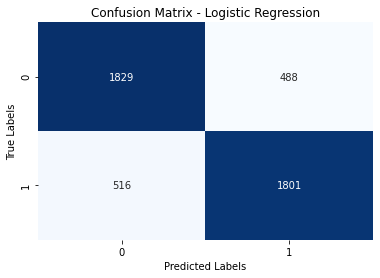

In [488]:
#Confusion matrix on test set - Non-normalized
cm = confusion_matrix(y_test, y_pred)

#ax = plt.axes()
sns.heatmap(cm, annot=True, cbar=False, fmt='g', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Text(0, 0.5, 'True Positive Rate')

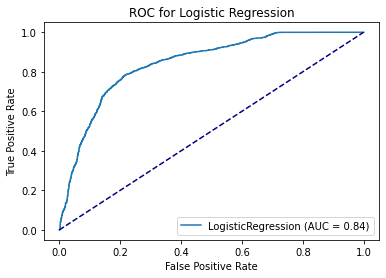

In [489]:
#ROC Curve
plot_roc_curve(lr, x_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

3.3.2) Random Forest Classifier

In [490]:
#Random Forest Model
rf = RandomForestClassifier(random_state=1)
rf_model = rf.fit(X_train, Y_train)
y_pred = rf_model.predict(x_test)

In [491]:
#Random Forest - Scores
rf_ac_train = rf.score(X_train, Y_train) 
rf_ac_test = rf.score(x_test, y_test)
rf_rocscore = roc_auc_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)

print('Scores - Random Forest Classifier:')
print(f'On Training data: {rf_ac_train.round(3)}')
print(f'On Testing data: {rf_ac_test.round(3)}')
print(f'On ROC Score: {rf_rocscore.round(3)}')
print(f'On F1 score: {rf_f1.round(3)}')
print(f'On Recall score: {rf_recall.round(3)}')

Scores - Random Forest Classifier:
On Training data: 0.998
On Testing data: 0.871
On ROC Score: 0.871
On F1 score: 0.86
On Recall score: 0.792


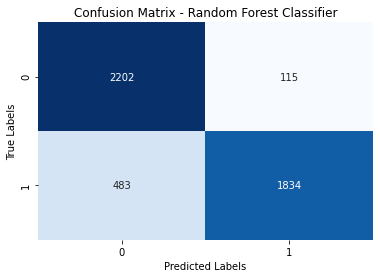

In [492]:
#Confusion matrix on test set - Non-normalized
cm = confusion_matrix(y_test, y_pred)

#ax = plt.axes()
sns.heatmap(cm, annot=True, cbar=False, fmt='g', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

Text(0, 0.5, 'True Positive Rate')

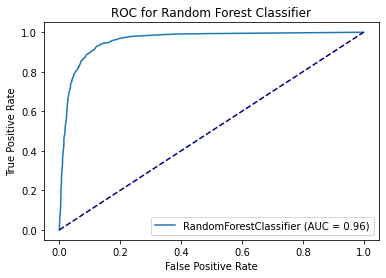

In [493]:
#ROC Curve
plot_roc_curve(rf, x_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC for Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

3.3.3) K-Nearest Neighbour Classifier

In [494]:
#KNN Classifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, Y_train)
y_pred = knn_model.predict(x_test)

In [495]:
#KNN Classifier Scores
knn_ac_train = knn.score(X_train, Y_train) 
knn_ac_test = knn.score(x_test, y_test)
knn_rocscore = roc_auc_score(y_test, y_pred)
knn_f1 = f1_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)

print('Scores - K-Nearest Neighbour Classifier:')
print(f'On Training data: {knn_ac_train.round(3)}')
print(f'On Testing data: {knn_ac_test.round(3)}')
print(f'On ROC Score: {knn_rocscore.round(3)}')
print(f'On F1 score: {knn_f1.round(3)}')
print(f'On Recall score: {knn_recall.round(3)}')

Scores - K-Nearest Neighbour Classifier:
On Training data: 0.949
On Testing data: 0.719
On ROC Score: 0.719
On F1 score: 0.672
On Recall score: 0.577


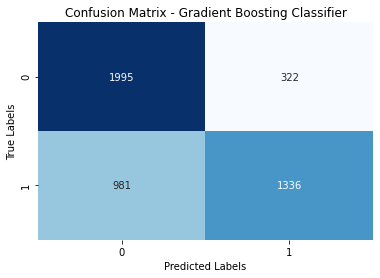

In [496]:
#Confusion matrix on test set - Non-normalized
cm = confusion_matrix(y_test, y_pred)

#ax = plt.axes()
sns.heatmap(cm, annot=True, cbar=False, fmt='g', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.show()

Text(0, 0.5, 'True Positive Rate')

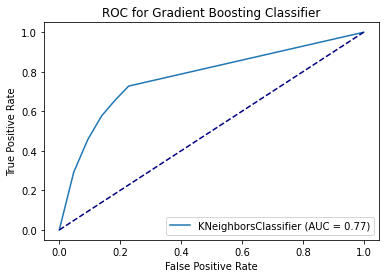

In [497]:
#ROC Curve
plot_roc_curve(knn, x_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC for Gradient Boosting Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

3.3.4) XGBoost Classifier

In [498]:
#XGBoost Classifier
xgb = XGBClassifier(n_estimator=500, random_state=1)
xgb_model = xgb.fit(X_train, Y_train)
y_pred = xgb_model.predict(x_test)

In [499]:
#XGBoost Scores
xgb_ac_train = xgb.score(X_train, Y_train)
xgb_ac_test = xgb.score(x_test, y_test)
xgb_rocscore = roc_auc_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)

print('Score - XGBoost Classifier:')
print(f'On Training data: {xgb_ac_train.round(3)}')
print(f'On Testing data: {xgb_ac_test.round(3)}')
print(f'On ROC Score: {xgb_rocscore.round(3)}')
print(f'On F1 score: {xgb_f1.round(3)}')
print(f'On Recall score: {xgb_recall.round(3)}')

Score - XGBoost Classifier:
On Training data: 0.913
On Testing data: 0.903
On ROC Score: 0.903
On F1 score: 0.907
On Recall score: 0.94


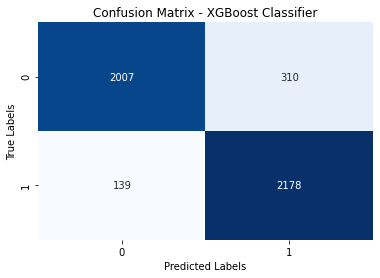

In [500]:
#Confusion matrix on test set - Non-normalized
cm = confusion_matrix(y_test, y_pred)

#ax = plt.axes()
sns.heatmap(cm, annot=True, cbar=False, fmt='g', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()

Text(0, 0.5, 'True Positive Rate')

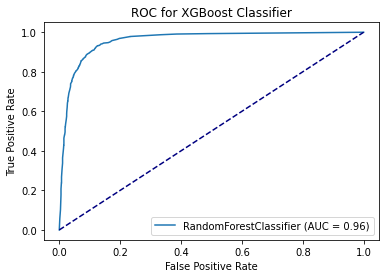

In [501]:
#ROC Curve
plot_roc_curve(rf, x_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC for XGBoost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## **4) Model Evaluation**




In [505]:
model_comp = pd.DataFrame({'Metrics/ Model': ['Accuracy Score (Test data)', 'ROC Score', 'F1 Score', 'Recall'],
                           'Logistic Regression': [lr_ac_test, lr_rocscore, lr_f1, lr_recall],
                           'Random Forest': [rf_ac_test, rf_rocscore, rf_f1, rf_recall],
                           'K-Nearest Neighbor': [knn_ac_test, knn_rocscore, knn_f1, knn_recall],
                           'XGBoost': [xgb_ac_test, xgb_rocscore, xgb_f1, xgb_recall],
                          }).round(3)

In [506]:
model_comp

,Metrics/ Model,Logistic Regression,Random Forest,K-Nearest Neighbor,XGBoost
0,Accuracy Score (Test data),0.783,0.871,0.719,0.903
1,ROC Score,0.783,0.871,0.719,0.903
2,F1 Score,0.782,0.860,0.672,0.907
3,Recall,0.777,0.792,0.577,0.940


Text(0, 0.5, 'True Positive Rate')

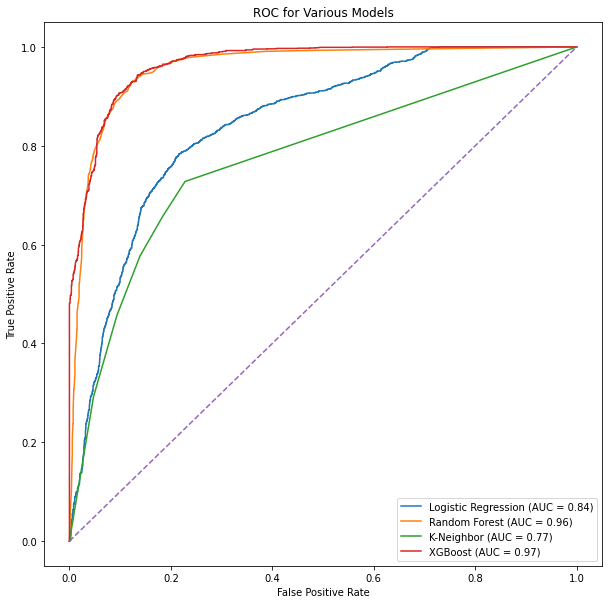

In [504]:
fig, ax = plt.subplots(figsize=(10,10))
lr_plot = plot_roc_curve(lr, x_test, y_test, name='Logistic Regression',ax=ax)
rf_plot = plot_roc_curve(rf, x_test, y_test, name='Random Forest',ax=ax)
knn_plot = plot_roc_curve(knn, x_test, y_test, name='K-Neighbor',ax=ax)
xgb_plot = plot_roc_curve(xgb, x_test, y_test, name='XGBoost',ax=ax)
plt.plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='baseline', linestyle='--')
plt.title('ROC for Various Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Among all the models tested, XGBoos yields the best AUC scores. <br>
The feature importance in predicting West Nile Viruses are:

In [523]:
features_col = features.columns.tolist()
importance = xgb_model.feature_importances_.tolist()

feat_imp_comb = zip(features_col, importance)

feat_imp = pd.DataFrame(feat_imp_comb, columns = ['Feature', 'Importance']) 

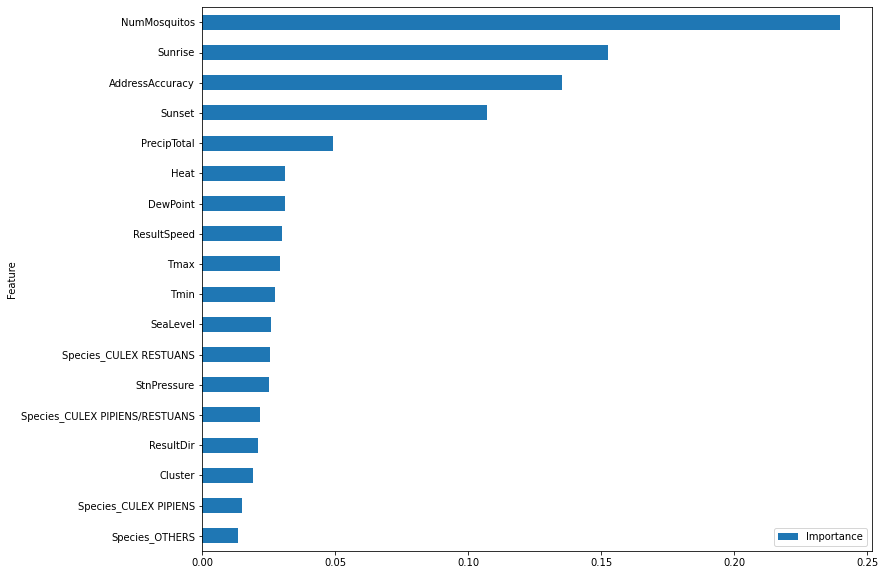

In [526]:
feat_imp.sort_values(by='Importance').plot(x='Feature', kind='barh', figsize=(12,10));